In [1]:
import seaborn as sns
sns.set()

In [2]:
import pandas as pd
import numpy as np
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats

# Outlier Detection
<!-- requirement: projects/anomaly -->

In many business applications, it is useful and important to identify "abnormal" or out-of-the-ordinary data points (outliers). In this notebook, we present a brief overview of applicable methods, and distinguish between **novelty detection** and **outlier detection**.

We present code examples for implementing each of these with Scikit-learn, and also include a more comprehensive **case study of novelty detection in time series data**.

## Motivation

In the case study later in this notebook, we use New York CitiBike ridership data. Finding out if a specific day had an unusual number of riders might be useful for a number of reasons.  That is, if there are an extra 5,000 riders one day, we probably want to know.  Was a particular advertisement very effective?  Did a celebrity tweet about the program?  Was there some event that attracted a lot of riders?  Regardless, marketing can probably use this information to refocus their efforts.

More importantly, if we're missing 5,000 riders we expected, something has gone wrong.  Did credit card processing break?  Did a backend server go down?  Did our redistribution scheme fail, leaving empty bike racks where the users are?  Or was there some unexpected failure mode that we weren't checking for?  Whatever it was, we want to know ASAP, so that we can address it.

This is true in general.  Any time your business has data coming in regularly, you want to know when it is behaving abnormally, so that you can quickly fix it. However, abnormal data could also be a sign that something is working better than it used to.  Either way, you want to know.

## Concepts

Depending on the type of data set that you have, we can distinguish two methods for attacking such problems: **novelty detection** and **outlier detection.**

If you are trying to identify abnormal or out-of-the-ordinary observations, and  you are starting out with a clean data set that is not polluted by outliers, then you are performing **novelty detection.**

On the other hand, if your data set already includes outliers, and you are looking to distinguish inliers from the current outliers and any new outliers in incoming data, then you are performing **outlier detection.** In this case, you do *not* have a clean data set.

## Scikit-learn Implementation

In Scikit-learn, both of these are implemented as **unsupervised learning** methods. Common algorithms include **One-class SVM** and **Isolation Forests.**

First, a few general notes:
* Learning is unsupervised
* `estimator.fit(X_train)` is used for fitting
* `estimator.predict(X_test)` is used for identifying inliers and outliers
* the `predict` method labels inliers as `1` and outliers (anomalies) as `-1`

## One-class SVM

For novelty detection, a One-class SVM tries to learn a frontier of the initial observations, which can then be used to classify subsequent observations as inliers or outliers, depending on the side of the frontier they are on.

You first fit the model and then apply `predict` to obtain inlier/outlier labels (1 or -1).

As a simple example, we'll fit a model to observations from the Iris data set. (Ignoring the usual labels and considering all observations to be inliers.) To facilitate visualization, we'll consider only the first two features. 

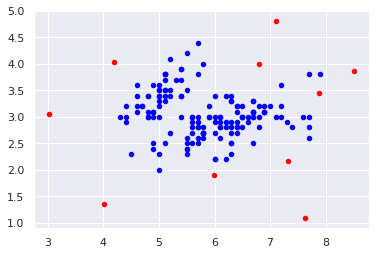

In [3]:
from sklearn import datasets
dataset = datasets.load_iris()
np.random.seed(10)

X_train = dataset.data[:,:2] 
X_test  = np.random.random((10,2))*np.array([6,4])+np.array([3,1]) # fake observations

def plot(arr, c="blue"):
    plt.scatter(arr[:,0], arr[:,1], s=20, c=c)
    
plot(X_train)
plot(X_test,c="red")

The blue points represent true observations, while the red points were randomly generated.  

In [4]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma="auto")
clf.fit(X_train)

y_pred_test = clf.predict(X_test)

float(sum(y_pred_test==-1))/len(y_pred_test) # proportion of outliers

1.0

In this case, the model labels all of the fake observations as outliers. This *doesn't* mean that the model is perfect; some of the true observations are also labeled as outliers. When working with low-dimensional data, plotting the decision function and decision boundary can give you a clear picture of what the model is doing.

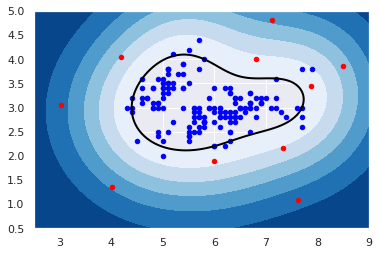

In [5]:
xx, yy = np.meshgrid(np.linspace(2.5, 9, 500), np.linspace(0.5, 5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

plot(X_train)
plot(X_test,c="red")

Mathematical and other **details** of Support Vector Machines in general, and One-class SVMs in particular, are contained in the [Support Vector Machines](AM_Support_Vector_Machines.ipynb) notebook. Briefly, when using One-class SVM, the analyst needs to:
1. choose a kernel (usually `RBF`)
1. set the margin $\nu$, which controls the number of false positives and false negatives. In other words, $\nu$ "corresponds to the probability of finding a new, but regular observation outside the frontier"


Per the [Scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py), "One-class SVM is known to be sensitive to outliers" and "is best suited for novelty detection when the training set is not contaminated by outliers" (the documentation also provides [distinction between outliers and novelties](http://scikit-learn.org/stable/modules/outlier_detection.html)). Still, "outlier detection in high-dimension, or without any assumptions on the distribution of the inlying data is very challenging, and a One-class SVM might give useful results in these situations."

## Isolation Forest

For detecting outliers, Isolation Forest (iForest) is a newer and more efficient method, especially for high-dimensional data sets. 

Isolation Forest exploits two characteristics of anomalous observations: they are  relatively few in number, and they are very different from "normal" values (Liu, Ting, and Zhou, 2008). An isolation forest aims to "isolate" the outliers based on these two facts, using an ensemble of classification trees. As shown in [Figure 1 in Liu, Ting, and Zhou, 2008 (PDF)](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest), the "isolation path" to an outlier is relatively shorter than the path to an inlier, for a single tree (and therefore, also for an ensemble of trees). Isolation Forest uses these intuitions, as well as a few other tricks (see below), to efficiently detect outliers.

### Isolation Forest in Scikit-learn


In [6]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, contamination=0.1, random_state=1001)
clf.fit(X_train)

y_pred_test = clf.predict(X_test)

float(sum(y_pred_test==-1))/len(y_pred_test) # proportion of outliers 

0.9

This model labels $90\%$ of the fake observations as outliers. To understand why, it can help to look at the decision function.

In [7]:
clf.decision_function(X_test)

array([-0.13904786, -0.03120632, -0.05129238, -0.09717997, -0.14325942,
       -0.12645803,  0.00401262, -0.07964995, -0.10749768, -0.12414602])

These scores are a non-linear function of the path-length metric and can take values between $-0.5$ and $0.5$. Higher values are less anomalous and lower values are more anomalous.

We can see that the decision function made by the isolation forest is different from that of the one-class SVM.

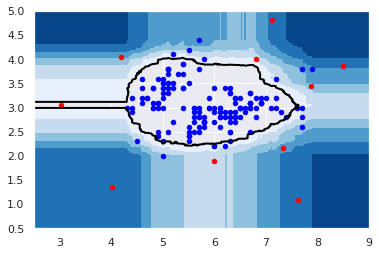

In [8]:
xx, yy = np.meshgrid(np.linspace(2.5, 9, 500), np.linspace(0.5, 5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

plot(X_train)
plot(X_test,c="red")

### Isolation Forest details


From Liu, Ting, and Zhou:

> In a data-induced random tree, partitioning of instances are repeated recursively until all instances are isolated. **This random partitioning produces noticeably shorter paths for anomalies** since (a) the fewer instances of anomalies result in a smaller number of partitions – shorter paths in a tree structure, and (b) instances with distinguishable attribute-values are more likely to be separated in early partitioning. Hence, **when a forest of random trees collectively produce shorter path lengths for some particular points, then they are highly likely to be anomalies**.

Advantages of iForest:

> * "The isolation characteristic of iTrees enables them to build partial models and **exploit sub-sampling** to an extent that is not feasible in existing methods. Since a large part of an iTree that isolates normal points is not needed for anomaly detection; it does not need to be constructed. A small sample size produces better iTrees because the swamping and masking effects are reduced."
* iForest utilizes no distance or density measures to detect anomalies. This **eliminates major computational cost** of distance calculation in all distance-based methods and density-based methods.
* **iForest has a linear time complexity** with a low constant and a low memory requirement. To our best knowledge, the best-performing existing method achieves only approximate linear time complexity with high memory usage [13].
* **iForest has the capacity to scale up to handle extremely large data size** and high-dimensional problems with a large number of irrelevant attributes.

[Emphases added]

### Summary


One-class SVM and Isolation Forest are two methods for detecting outliers. One-class SVM usually works better on data with multiple modes, while Isolation Forest works well across diverse data sets. In the end, perhaps the distinction between novelty and outlier detection is not that important in practice.

Isolation Forest reference (PDF):
* [Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM‘08. Eighth IEEE International Conference](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)

More resources:
* [Scikit-learn user guide](http://scikit-learn.org/stable/modules/outlier_detection.html) for novelty and outlier detection
* See the above link for more example code, including [this comparison of outlier detection](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py) with several methods

## Case Study: Anomaly Detection in Time Series

Next, we present a case study for detecting anomalies in time series data.  Time-series analysis is discussed in more detail in the [Time Series](AM_Time_Series.ipynb) notebook.

For our example data, we will be using ridership of the New York CitiBike bike sharing system.  The full data are available [online](https://s3.amazonaws.com/tripdata/index.html), but we will be using a data file in which the ridership has already be aggregated by day.



In [ ]:
counts = pd.read_csv('projects/anomaly/citibike.csv').set_index('date')['count']
counts.index = pd.to_datetime(counts.index, format='%Y-%m-%d')
counts.head()

In [ ]:
counts.plot()
plt.ylabel('Rides per day');

## Modeling the background


There are clearly days in this data that do not follow the overall trend.  For example, there is a day in early October, 2015, which has much less ridership than we would expect.  However, this amount of ridership would be perfectly normal in the winter of 2014 or 2015.  To make this stand out, we build a model of the expected ridership.


## Detecting seasonality with Fourier Transforms


As a reminder from the [Time Series](AM_Time_Series.ipynb) notebook, seasonality is the periodic correlation of a time series with itself.  Fourier analysis can be used to detect seasonality that occurs over all time.

In this case, we plot the **power spectrum** of the signal, which is the Fourier transform times its conjugate, or equivalently the square of the absolute value of the transform.  In many cases in physics, the power in a signal goes like the square of the amplitude.  In these cases, the power spectrum describes the power per unit frequency contained in that signal.

Looking at the lower frequency components, we can clearly see the yearly cycle that's obvious by eye.

In [ ]:
fft_counts = np.fft.fft(counts - counts.mean())
yrs = (counts.index[-1] - counts.index[0]).days / 365.

plt.plot(1.0*np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0, 3, 0, 5e13])
plt.xlabel('Freq (1/yrs)');

**Question:** What does the peak at 2/year indicate?

Changing focus to some higher frequencies, we can clearly see the weekly cycle, at 52/year.

In [ ]:
plt.plot(1.0*np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0, 100, 0, 1e12])
plt.xlabel('Freq (1/yrs)')
plt.axvline(365/7., color='k', ls=':')
plt.axvline(12, color='k', ls=':')
plt.axvline(8, color='k', ls=':');

**Question:** There are clear peaks at 12/year and 8/year.  What might cause these?

## Detrending


The yearly cycle appears to be rather sinusoidal, so we account for it with a single Fourier term:

$$ f(t) = A \sin\frac{2\pi t}{365} + B\cos\frac{2\pi t}{365} + f_0 \ . $$

Since we know the frequency, we can fit the coefficients $A$, $B$, and $f_0$ with linear regression.  To do so, we need to engineer additional features for the sine and cosine terms.  To help us out, and because we will want to add additional seasonal features, let's define a custom transformer to which we can supply a period.

In [ ]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

pipe = Pipeline([('fourier', FourierComponents(365)),
                 ('lr', LinearRegression())])
pipe.fit(counts.index, counts)
plt.plot(counts.index, counts, counts.index, pipe.predict(counts.index));

How well are we doing?  A good baseline is the mean model, which has a MSE equal to the variance of the data.  We'll take the square root to look at RMSE.

In [ ]:
np.sqrt(counts.var())

Another metric we can consider is the $R^2$ score.  This will be very bad for the mean model.  

In [ ]:
metrics.r2_score(counts, [counts.mean()]*len(counts))

Our first model is definitely an improvement:

In [ ]:
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

And here's the $R^2$ score for this first model.  

In [ ]:
metrics.r2_score(counts, pipe.predict(counts.index))

### Weekly cycle


We could add a weekly Fourier term, but we don't know if it's really sinusoidal.  If we group the results by day of the week, we can get a better feel for the cycle.

In [ ]:
day_df = pd.DataFrame(
    {'day': counts.index.dayofweek, 'count': counts.values}
)
day_df.groupby('day').mean().plot(kind='bar')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

The weekly cycle is not particularly sinusoidal.  Instead of treating the day of the week as a continuous variable, we will treat it as a categorical feature.  We will use one-hot encoding of the day of the week.  When this is fed into a linear regression, it produces per-category means.

In [ ]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.day_vector(d) for d in X.dayofweek])

union = FeatureUnion([('fourier', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

pipe.fit(counts.index, counts)
print("RMSE:", np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index))))
print("R^2:", metrics.r2_score(counts, pipe.predict(counts.index)))

To understand what a model is doing correctly, and what it's missing, it's useful to plot the **residual**, the difference between the actual and predicted values.

In [ ]:
plt.plot(counts - pipe.predict(counts.index));

Ridership has been growing with time.  The growth doesn't appear to be linear, but quadratic might be a good fit.  It's simple to add two more features representing $t$ and $t^2$ to attempt to fit this background growth.

In [ ]:
class QuadBackground(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]

union = FeatureUnion([('date', QuadBackground()),
                      ('fourier', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

pipe.fit(counts.index, counts.values)
plt.plot(counts - pipe.predict(counts.index));

In [ ]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index))))
print("R^2:", metrics.r2_score(counts, pipe.predict(counts.index)))

**Exercises**

1. Account for the monthly seasonality.  Examine how ridership varies over the month.  Develop a model to account for this.  How much does this improve the RMSE and $R^2$ value?

2. It seems reasonable to assume that weather affects the usage of the CitiBike system.  The `projects/anomaly/nycp.csv` file contains daily National Weather Service records for Central Park.  Add features from these records to your model.  Does this improve the RMSE of the model?  How much does ridership increase for every degree Fahrenheit?  (Hint: The coefficients of the linear model are stored in the `.coef_` attribute of a `LinearRegression` object.)

### Full background model

In addition to the yearly Fourier term and weekly binning, we have added monthly, biannual, and 8/year Fourier components.

In [ ]:
union = FeatureUnion([('date', QuadBackground()),
                      ('fourier-y', FourierComponents(365)),
                      ('fourier-2', FourierComponents(365/2.)),
                      ('fourier-m', FourierComponents(365/12.)),
                      ('fourier-8', FourierComponents(365/8.)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])
pipe.fit(counts.index, counts.values)
print("RMSE:", np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index))))
print("R^2:", metrics.r2_score(counts, pipe.predict(counts.index)))

This is a fair improvement on our previous RMSE and $R^2$.

In [ ]:
residuals = counts - pipe.predict(counts.index)
plt.plot(residuals);

## z-Score


From the residuals plot above, we can fairly easily see which values are likely to be anomalous: those far from zero.  We can quantify this measure with some results from statistics.

Suppose that we have a probability distribution with mean $\mu$ and standard deviation $\sigma$.  If the distribution is single-peaked, we expect most random variables pulled from it to lie within about $1\sigma$ of $\mu$.  Now, we ask whether a particular value $y$ was likely to have been drawn from that distribution.  The **z-score** measures how far $y$ is from the mean, normalized by the standard deviation:

$$ z = \frac{y - \mu}\sigma \ . $$

Many random variables follow the Gaussian, or normal, distribution.  This is the common bell curve, which is parameterized by its mean and standard deviation:

$$ p(x) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(x - \mu)^2}{2 \sigma^2} \right) \ . $$

In [ ]:
x = np.linspace(-4, 4, 100)
dist = stats.norm()
cols = sns.color_palette()[::2]
cols = [cols[1], cols[2], cols[0], cols[0], cols[2], cols[1]]
plt.plot(x, dist.pdf(x))
for xm in range(-2, 4):
    x = np.linspace(xm-1, xm, 20)
    plt.fill_between(x, dist.pdf(x), alpha=0.5, lw=0, facecolor=cols[xm+2])
plt.xlabel(r'$(x - \mu) / \sigma$');

For a Gaussian, there is 68% chance of a random variable lying within $1\sigma$ of the mean (blue), a 95% chance of it lying withing $2\sigma$ (blue and yellow), and a 99.7% chance of it lying within $3\sigma$ (blue, yellow and red).  Thus, the higher the z-score of a value, the less likely it is to have been drawn from that distribution.

Of course, different distributions have different shapes, so these probabilities are not universal.  Nonetheless, for single-peaked distributions, the general pattern holds.

In [ ]:
residuals.hist(bins=50)
x = np.arange(-30000, 15000, 100)
dist = stats.norm(scale=residuals.std())
plt.plot(x, dist.pdf(x) * 45000 / 50. * len(residuals));

The residuals are not distributed normally, but we can still use large (absolute) z-scores as an indicator.

In [ ]:
z = residuals / residuals.std()
plt.plot(z)
plt.ylabel('z-score');

Since the distribution of residuals is not symmetric about 0, we will consider different thresholds for positive and negative z values.

In [ ]:
z[z > 2]

Looking at news reports, we can try to understand what might have caused these events.  We can find that March 9 and 10 of 2016 were particularly nice.  High temperatures were in the 70s, unusual for March in New York.

In [ ]:
z[z < -3.5]

We can now see that early October, 2015, an event occurred on the second.  It happens that on this day, a nor'easter blew through New York.

## Moving-Window Averages


One thing to note about these results is that most of the anomalous counts are rather recent.  Looking at the residuals, we can see why: There seems to be more variation in the recent data.  This suggests that we should be looking for measures that compare the latest results only to contemporary data.

This is the domain of **moving-window averages**.  Instead of calculating values over the whole of the domain, we do the calculation over a window.  As we move forward in time, this window moves with us.  There are a number of window shapes we could use, but we will start with a simple square window of the last $k$ measurements.  Pandas makes it easy to calculate the mean and standard deviation over those windows.

In [ ]:
from ipywidgets import interact

def plot_rolling(x):
    
    def func(window=50):
        rolling = x.rolling(window=window)
        plt.plot(x, lw=1)
        mean = rolling.mean()
        std = rolling.std()
        plt.fill_between(mean.index, mean+std, mean-std, facecolor=cols[1], alpha=0.5)
        plt.plot(rolling.mean())
    
    return func

interact(plot_rolling(residuals), window=(5, 100, 5));

If we use these rolling values for mean and standard deviation, we get the **moving z-score**.

In [ ]:
def rolling_z(x, window):
    roll_mean = x.rolling(window=window).mean().shift(1) # Don't include current data
    roll_std = x.rolling(window=window).std().shift(1)
    return (x - roll_mean) / roll_std

In [ ]:
def plot_rolling_z(x):
    return lambda window: plt.plot(rolling_z(x, window)) and None

interact(plot_rolling_z(residuals), window=(5, 100, 5));

While the choice of window size will always reflect a balance between the need to respond to new baselines while still noticing anomalous behavior, we can get an estimate for the size of the window we should use from the autocorrelation of the residuals.  In this case, the strong correlation only lasts about 5 days.

In [ ]:
pd.plotting.autocorrelation_plot(residuals)
plt.xlim(0, 40);

In [ ]:
rolling_z(residuals, 5)[rolling_z(residuals, 5) > 5]

In [ ]:
rolling_z(residuals, 5)[rolling_z(residuals, 5) < -10]

The October nor'easter no longer stands out as strongly.  Ridership fell for several days before the storm (perhaps due to precursor weather), so the drop on the day of the storm is less surprising.

One new date that appears is worth noting: March 28, 2015.  On this day, the CitiBike program was suddenly [shut down for software fixes](http://www.nytimes.com/2015/03/31/nyregion/citi-bike-apologizing-for-abrupt-shutdown-says-service-will-improve.html?_r=0).

### Exponential Window


A particularly simple windowing average is the **exponentially-weighted moving average** (EWMA).  The value at time $t$ is given by

$$ E_t = \alpha X_t + (1 - \alpha) E_{t-1}\ \ \ \ \textrm{where } 0 \leq \alpha \leq 1. $$

This has the effect of previous measurements fading away by a factor of $1 - \alpha$ each step.  Previous values are never entirely forgotten, but they fade away bit by bit.  This simple form makes it easy to calculate.  Regardless of the window size, we need hold only the previous value of the moving average in memory.

There are several ways to specify the parameter; here we use the **half-life**,

$$ h = \frac{\ln(0.5)}{\ln(1-\alpha)} \ . $$

In [ ]:
def plot_ewm(x):
    
    def func(halflife=50):
        rolling = x.ewm(halflife=halflife)
        plt.plot(x, lw=1)
        mean = rolling.mean()
        std = rolling.std()
        plt.fill_between(mean.index, mean+std, mean-std, facecolor=cols[1], alpha=0.5)
        plt.plot(rolling.mean())
    
    return func

interact(plot_ewm(residuals), halflife=(5, 100, 5));

In [ ]:
def ewm_z(x, halflife):
    ewm_mean = x.ewm(halflife=halflife).mean().shift(1) # Don't include current data
    ewm_std = x.ewm(halflife=halflife).std().shift(1)
    return (x - ewm_mean) / ewm_std

In [ ]:
def plot_ewm_z(x):
    return lambda halflife: plt.plot(ewm_z(x, halflife)) and None

interact(plot_ewm_z(residuals), halflife=(5, 100, 5));

In [ ]:
ewm_z(residuals, 5)[ewm_z(residuals, 5) > 2]

In [ ]:
ewm_z(residuals, 5)[ewm_z(residuals, 5) < -4]

## Including windowed data in model


Instead of adapting our metric to consider recent data, we can include that recent data in the model.  Here, we have two features: the count from the previous day, and a five-day rolling average.  There is a little bit of work necessary to hook all the components of the pipeline together, but in the end there is just a linear regression being performed.

In [ ]:
counts_df = pd.DataFrame({'counts': counts, 'previous': counts.shift(1).fillna(method='bfill'),
                          'rolling': counts.rolling(window=5).mean().shift(1).fillna(method='bfill')}) 

In [ ]:
class IndexExtractor(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index

class ColumnExtractor(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

In [ ]:
time_pipe = Pipeline([('index', IndexExtractor()),
                      ('features', union)])
all_union = FeatureUnion([('time_pipe', time_pipe),
                          ('columns', ColumnExtractor(['previous', 'rolling']))])
lr_pipe = Pipeline([('all_union', all_union),
                    ('lr', LinearRegression())])

In [ ]:
lr_pipe.fit(counts_df, counts_df['counts'])
print("RMSE:", np.sqrt(metrics.mean_squared_error(counts, lr_pipe.predict(counts_df))))
print("R^2:", metrics.r2_score(counts, lr_pipe.predict(counts_df)))

This models scores significantly better.  It is also much more stationary.

In [ ]:
residuals_window = counts_df['counts'] - lr_pipe.predict(counts_df)
z_window = residuals_window / residuals_window.std()
plt.plot(z_window);

In [ ]:
z_window[z_window > 2]

In [ ]:
z_window[z_window < -3.5]

## Bayesian Changepoints


The previous model does a good job at producing a stationary signal, but there appear to be occasional changes in the variance.  One tool to deal with this is **Bayesian changepoint detection**.

[Bayesian changepoint detection](https://arxiv.org/pdf/0710.3742.pdf) assumes that we have a signal drawn i.i.d. from some distribution.  However, at some (randomly occurring) points in time, the parameters of that distribution change.  We keep an estimate of the probability that it has been $T$ steps from the last changepoint, for all values of $T$.  As each new measurement $X_t$ comes in, we update the probabilities for each length run, conditioned on the newest measurement.  (Therefore, we need to track the mostly-probable parameters for the distribution, given each length run.)

The algorithm needs to know what the underlying distribution is, what the Bayesian priors of the parameters are, and what the expected distribution of run lengths is.  The implementation below uses a Gaussian distribution for the samples and a geometric distribution for the run lengths.

In [ ]:
# Adapted from Ryan P. Adams's Matlab code: http://hips.seas.harvard.edu/content/bayesian-online-changepoint-detection

def bayes_changepoint(X, mu0, sigma0, lambda_):
    """
    Perform Bayesian changepoint detection on an input signal X.
    
    The underlying distribution is Gaussian.  The Bayesian priors on the mean and standard
    deviation are mu0 and sigma0.  Run lengths are geometrically distributed with paramater
    lambda_.  (Equivalently, there is a probability of lambda_ of a new run starting at each
    time step.)
    
    Returns a tuple of three values:
      1) A matrix of the run length probabilities for each time step.
      2) A vector of the most probable value of the mean for each time step.
      3) A vector of the most probably value of the standard deviation for each time step.
    """
    T = len(X)
    R = np.zeros([T+1, T+1])
    R[0,0] = 1
    
    kappa0 = 1
    alpha0 = 1
    beta0 = sigma0**2 / 2

    muT = np.array(mu0)
    kappaT = np.array(kappa0)
    alphaT = np.array(alpha0)
    betaT = np.array(beta0)

    mp_mean = np.zeros(T)
    mp_std = np.zeros(T)

    maxes = np.zeros(T+1)
    for t in range(T):
        xt = (X[t] - muT) / np.sqrt(betaT * (kappaT+1) / (alphaT * kappaT))
        predprobs = stats.t.pdf(xt, 2 * alphaT)
        H = np.ones(t+1) / lambda_

        R[1:t+2, t+1] =  R[:t+1,t] * predprobs * (1 - H)
        R[0,     t+1] = (R[:t+1,t] * predprobs * H).sum()
        R[:,t+1] = R[:,t+1] / R[:,t+1].sum()  # Numerics

        mp = R[:, t+1].argmax()

        muT0 = np.r_[mu0, (kappaT * muT + X[t]) / (kappaT + 1)]
        kappaT0 = np.r_[kappa0, kappaT + 1]
        alphaT0 = np.r_[alpha0, alphaT + 0.5]
        betaT0 = np.r_[beta0, betaT + (kappaT * (X[t] - muT)**2 / (2 * (kappaT + 1)))]

        muT = muT0
        kappaT = kappaT0
        alphaT = alphaT0
        betaT = betaT0

        mp_mean[t] = muT[mp]
        mp_std[t] = np.sqrt(betaT[mp] * (kappaT[mp] + 1) / (alphaT[mp] * kappaT[mp]))
    
    return R, mp_mean, mp_std

In [ ]:
R, mp_mean, mp_std = bayes_changepoint(residuals_window, 0, residuals_window.std(), 1000)
#This prevents taking the log of zeroes
posR = R[:]
posR[posR == 0] = 1e-10
plt.imshow(np.log10(posR), vmin=-3, origin='lower')
plt.colorbar(label=r'$\log_{10} P$')
plt.plot(residuals_window.values/100 + 900, lw=0.5)
plt.plot(R.argmax(axis=0), alpha=0.5, c='y')
plt.axis([0,len(residuals_window),0,len(residuals_window)])
plt.xlabel('t')
plt.ylabel('Current run length');

The black-and-white plot shows the logarithm of the probability of having a run of a particular length at time $t$.  The yellow line highlights the most probable run length at each time.  The saw-tooth pattern shows that, at most times, the most-probable run length increases by one.  In other words, each increasing line indicates a single run, and each point where the curve drops down to (or near) zero indicates a new changepoint.  The fact that each saw-tooth starts near the x-axis indicates that the algorithm detects changepoints soon after they occur.

The (residual of the) signal is plotted in blue.  You can notice that most of the changepoints correspond to a change in the variance of the signal.

From the most probable run, we can calculate the mean and standard deviation associated with that run.  This provides another way to calculate a moving z-score.

In [ ]:
plt.plot(residuals_window, lw=1)
plt.fill_between(residuals_window.index, mp_mean+mp_std, mp_mean-mp_std, facecolor=cols[1], alpha=0.5)
plt.plot(residuals_window.index, mp_mean);

In [ ]:
plt.plot(residuals_window / mp_std);

## Online Learning


So far, we have been doing only retrospective analysis of the data.  In practice, we want to analyze incoming data in real time.  While we could train a model on an initial set of data and use that to analyze the future input, this means we don't learn anything from that future data.  (Extrapolation is also very dangerous if you have a quadratic background term.)

In [ ]:
future_dates = pd.date_range('2013-07-01', '2023-07-01', freq='d')
plt.plot(future_dates, pipe.predict(future_dates));

We can avoid retraining the model each time we get new data by using an **online** learning algorithm, which is able to update itself with new data.  An exponentially-weighted moving average can be thought of as a simple online learning algorithm.  We can update its value from only the current value and the new measurement.  (In contrast, a rolling window requires us to store all the values in the window and recalculate the mean each step.)

The Bayesian changepoint algorithm shown above is also an online learning model, as it updates its state for each new sample.  As implemented above, its memory requirements would grow with the length of the data, as it considers run lengths that go back to $t=0$.  This could be avoided by truncating long run lengths when their probability falls below some threshold.

Linear regression does not support online learning.  However, stochastic gradient descent does.  Like linear regression, this is also a linear model.  Instead of finding an exact solution with matrix operations, stochastic gradient descent goes through the data row by row, updating its parameters slightly each time to reduce an error function.  Thus, it naturally supports online learning.

In Scikit-learn, estimators that support online learning do so through a `partial_fit()` method.  Unfortunately, the default `Pipeline` class does not support `partial_fit()`, so we implement it ourselves.

In [ ]:
class PartialFitPipeline(Pipeline):
    
    def partial_fit(self, X, y):
        # Assume that transformers without a partial_fit method can be skipped
        Xtrans = X
        for _, step in self.steps[:-1]:
            if hasattr(step, 'partial_fit'):
                step.partial_fit(Xtrans, y)
            Xtrans = step.transform(Xtrans)
        self.steps[-1][1].partial_fit(Xtrans, y)
        return self

sgd_pipe = PartialFitPipeline([('all_union', all_union),
                               ('scaler', StandardScaler()),
                               ('sgd', SGDRegressor(max_iter=100))])

We use an exponentially-weighted moving average, since it's easier to manage in online learning.  Stochastic gradient descent is sensitive to different scales of data, so we need to normalize the features coming in.

In [ ]:
counts_init = counts.iloc[:700]
counts_online = counts.iloc[700:]
counts_init_df = pd.DataFrame({'counts': counts_init,
                               'previous': counts_init.shift(1).fillna(method='bfill'),
                               'rolling': counts_init.ewm(halflife=5).mean().shift(1).fillna(method='bfill')}) 
sgd_pipe.fit(counts_init_df, counts_init_df['counts'])

At each step, we make a prediction for the incoming record.  Then we train the model on the new record and update for the next record.

In [ ]:
last_count = counts_init_df['counts'].iloc[-1]
alpha = 1 - 1./2**5
ewm = counts_init_df['rolling'].iloc[-1]
predictions = []
coefs = []

for date, count in counts_online.iteritems():
    df = pd.DataFrame({'counts': count, 'previous': last_count, 'rolling': ewm}, index=[date])
    predictions.append(sgd_pipe.predict(df))
    sgd_pipe.partial_fit(df, df['counts'])
    coefs.append(sgd_pipe.named_steps['sgd'].coef_.copy())
    last_count = count
    ewm = alpha * count + (1 - alpha) * ewm

In [ ]:
plt.plot(counts_online, label='data')
plt.plot(counts_online.index, predictions, label='model')
plt.legend(loc=4);

We can see that the model is adjusting the coefficients over time, as it continues to learn from the new data.

In [ ]:
plt.plot(coefs);

**Exercises:**

1. Add more lagged or windowed data to the model, and see if its performance can be improved.  Beware that, if too many features are added, there is a danger of overfitting.

2. Perform anomaly detection on the temperature data from the Central Park weather station.  Do temperature anomalies tend to align with ridership anomalies?  Add features to the ridership model corresponding to the temperature anomaly.  How does the performance of this model compare to one that involves temperature directly?

3. We have been looking at only aggregate data so far.  Instead, look at the ridership at a particular station, and try to detect anomalies in its data.  Do these anomalies line up with the system-wide anomalies or not?

## References


- ["Bayesian Online Changepoint Detection"](https://arxiv.org/abs/0710.3742), by Ryan Prescott Adams and David J.C. MacKay
- ["Is Seattle Really Seeing an Uptick In Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), by Jake VanderPlas
- ["Anomaly Detection"](https://turi.com/learn/userguide/anomaly_detection/intro.html), Turi User Guide

*Copyright &copy; 2020 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*